In [ ]:
# Load modules and set-up test problem
import sys
# sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt

import cuqi
from cuqi.testproblem import Deconvolution1D, Deconvolution2D
from cuqi.distribution import Gaussian, Gamma, JointDistribution
from cuqi.implicitprior import RegularizedGaussian, RegularizedGMRF, RegularizedUniform
from cuqi.sampler import RegularizedLinearRTO, Gibbs, Conjugate

# Set seed
np.random.seed(41)

print("Pre-implemented constraints: ", RegularizedGaussian.constraint_options())
print("Pre-implemented regularization: ", RegularizedGaussian.regularization_options())

# Create a new sampler class with preset parameters
def make_RegularizedLinearRTO(x0 = None, maxit = 100, stepsize = "automatic", rho = 10.0, adaptive = True):
    # Wrapper to tune the parameters
    class _RegularizedLinearRTO(RegularizedLinearRTO):
        def __init__(self, target):
            super().__init__(target, x0=x0, maxit=maxit, stepsize = stepsize, rho = rho, adaptive = adaptive)

    return _RegularizedLinearRTO


# Example set-up

In [ ]:
phantom = 'pc'#'square'#'hat'#'skyscraper'
n = 128
A, y_data, info = Deconvolution1D(dim=n, phantom=phantom, noise_std = 0.05, PSF_param = 3).get_components()

num_samples = 100
num_burnin = 10

print(A.domain_geometry)

plt.figure(figsize = (8,2))
plt.subplot(1,2,1)
info.exactSolution.plot()
plt.title("Exact solution")

plt.subplot(1,2,2)
y_data.plot()
plt.title("Data")

# Nonnegativity constraints with Gibbs

In [ ]:
l = Gamma(1, 1e-4)
d = Gamma(1, 1e-4)
x = RegularizedGMRF(mean = np.zeros(n), prec = lambda d : d, constraint="nonnegativity")
y = Gaussian(A@x, prec = lambda l : l)

# Combine into a joint distribution
joint = JointDistribution(l, d, x, y)
posterior = joint(y=y_data)

sampling_strategy = {
    'x': RegularizedLinearRTO,
    'l': Conjugate,
    'd': Conjugate
}

sampler = Gibbs(posterior, sampling_strategy)
samples = sampler.sample(num_samples, num_burnin)

samples['l'].plot_trace()
samples['d'].plot_trace()
plt.figure()
samples['x'].plot_ci()
plt.plot(info.exactSolution)

plt.figure()
samples['x'].plot_ci_width()

# $L_1$ regularization with Gibbs

c:\Users\jmev\Documents\GitHub\CUQIpy\cuqi\distribution\_gaussian.py:673: RuntimeWarning: divide by zero encountered in log
  logdet = np.sum(-np.log(precision))


Warmup 10 / 10
Sample 100 / 100


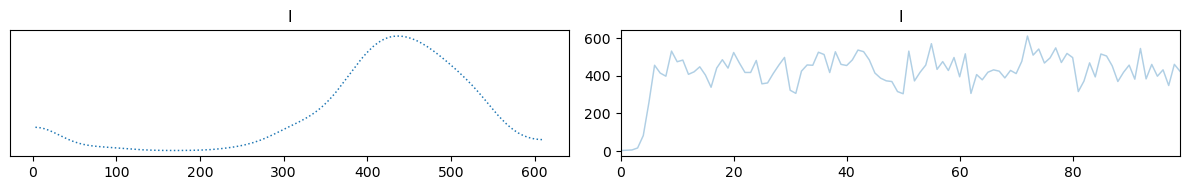

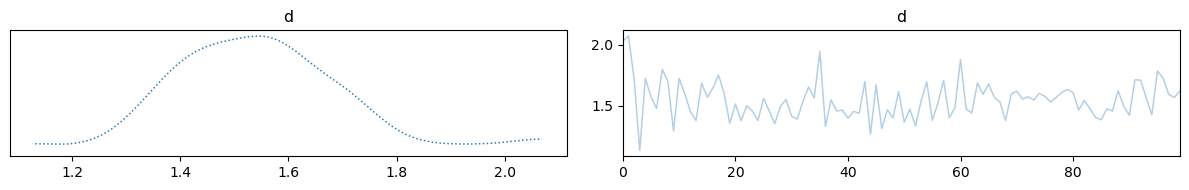

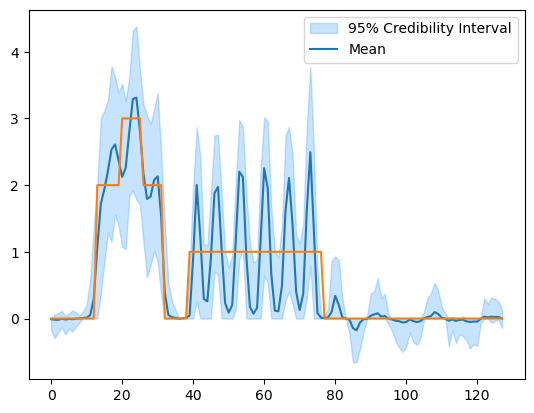

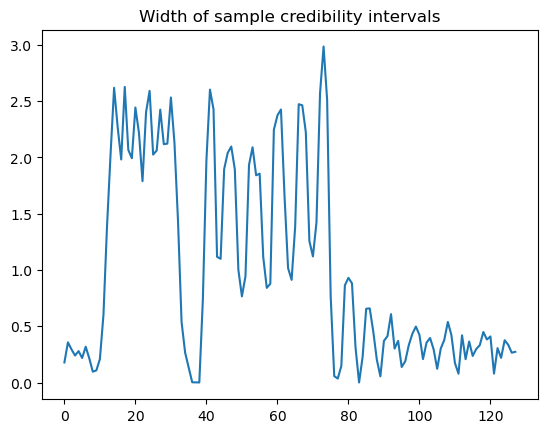

In [8]:
l = Gamma(1, 1e-4)
d = Gamma(1, 1e-4)
x = RegularizedUniform(regularization = "l1", strength = lambda d : d, geometry = A.domain_geometry, force_list=True)
y = Gaussian(A@x, prec = lambda l : l)

# Combine into a joint distribution
joint = JointDistribution(l, d, x, y)
posterior = joint(y=y_data)

sampling_strategy = {
    'l': Conjugate,
    'd': Conjugate,
    'x': make_RegularizedLinearRTO(maxit=100, rho = 10.0, adaptive = False)
}


sampler = Gibbs(posterior, sampling_strategy)
samples = sampler.sample(num_samples, num_burnin)

samples['l'].plot_trace()
samples['d'].plot_trace()
plt.figure()
samples['x'].plot_ci()
plt.plot(info.exactSolution)

plt.figure()
samples['x'].plot_ci_width()

Warmup 10 / 10
Sample 100 / 100


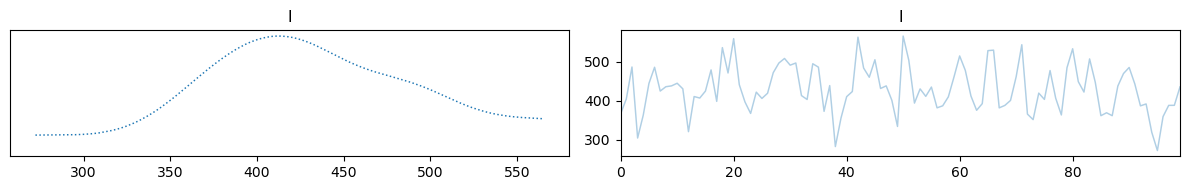

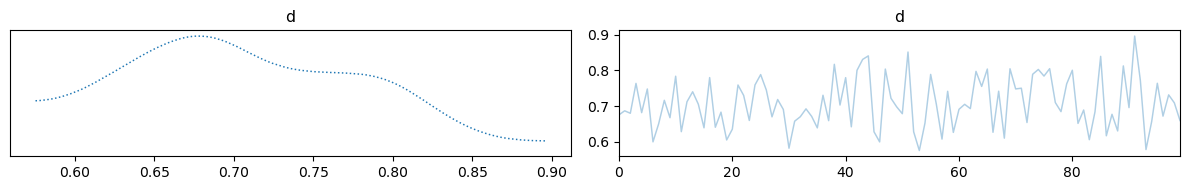

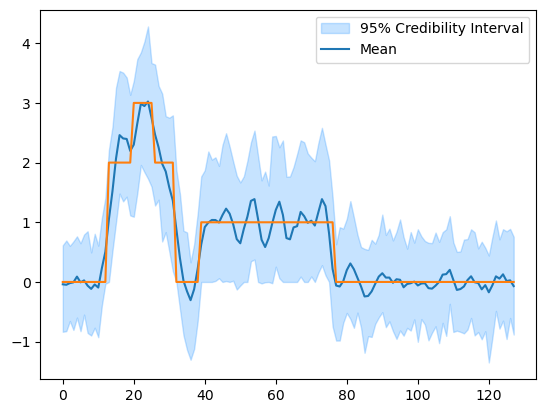

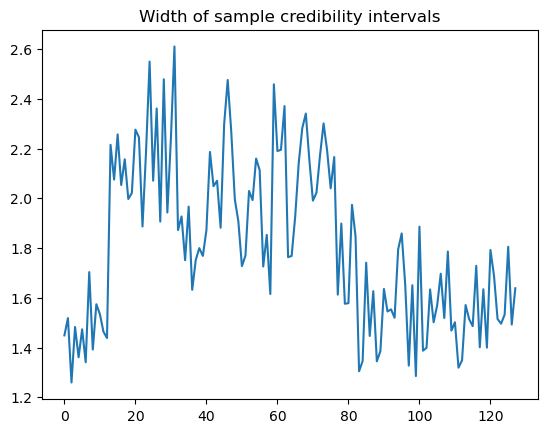

In [9]:
l = Gamma(1, 1e-4)
d = Gamma(1, 1e-2)
x = RegularizedGMRF(mean = np.zeros(n), prec = lambda d : 10*d**2, # Note: this must be quadratic
                    regularization = "l1", strength = lambda d : d, # Note: this must be linear
                    geometry = A.domain_geometry, force_list=True)
y = Gaussian(A@x, prec = lambda l : l)

# Combine into a joint distribution
joint = JointDistribution(l, d, x, y)
posterior = joint(y=y_data)

sampling_strategy = {
    'l': Conjugate,
    'd': Conjugate,
    'x': make_RegularizedLinearRTO(maxit=100, rho = 10.0, adaptive = False)
}

sampler = Gibbs(posterior, sampling_strategy)
samples = sampler.sample(num_samples, num_burnin)

samples['l'].plot_trace()
samples['d'].plot_trace()
plt.figure()
samples['x'].plot_ci()
plt.plot(info.exactSolution)

plt.figure()
samples['x'].plot_ci_width()

# TV regularization with Gibbs

In [ ]:
l = Gamma(1, 1e-4)
d = Gamma(1, 1e-4)
x = RegularizedUniform(A.domain_geometry,
                       regularization = "TV", strength = lambda d : d)
y = Gaussian(A@x, prec = lambda l : l)

# Combine into a joint distribution
joint = JointDistribution(l, d, x, y)
posterior = joint(y=y_data)

sampling_strategy = {
    'x': make_RegularizedLinearRTO(x0=None, maxit=100, rho = 10.0, adaptive = False),
    'l': Conjugate,
    'd': Conjugate,
}

sampler = Gibbs(posterior, sampling_strategy,
                sampling_order = ['x', 'l', 'd'],
                initial_guess = {'l': 100, 'd':100})
samples = sampler.sample(num_samples, num_burnin)

samples['l'].plot_trace()
samples['d'].plot_trace()
plt.figure()
samples['x'].plot_ci()
plt.plot(info.exactSolution)

plt.figure()
samples['x'].plot_ci_width()

# Nonnegativity constrained TV with Gibbs

In [ ]:
l = Gamma(1, 1e-4)
d = Gamma(1, 1e-4)
x = RegularizedUniform(A.domain_geometry,
                       constraint = "nonnegativity",
                       regularization = "TV", strength = lambda d : d)
y = Gaussian(A@x, prec = lambda l : l)

# Combine into a joint distribution
joint = JointDistribution(l, d, x, y)
posterior = joint(y=y_data)

sampling_strategy = {
    'x': make_RegularizedLinearRTO(x0=None, maxit=100, rho = 10.0, adaptive = False),
    'l': Conjugate,
    'd': Conjugate,
}

sampler = Gibbs(posterior, sampling_strategy,
                sampling_order = ['x', 'l', 'd'],
                initial_guess = {'l': 100, 'd':100})
samples = sampler.sample(100)

samples['l'].plot_trace()
samples['d'].plot_trace()
plt.figure()
samples['x'].plot_ci()
plt.plot(info.exactSolution)

plt.figure()
samples['x'].plot_ci_width()

# Example of user-defined nonnegativity constrained TV

In [ ]:
from cuqi.operator import FirstOrderFiniteDifference
fd = np.array(FirstOrderFiniteDifference(n-1, bc_type='zero').get_matrix().todense()).T

from cuqi.solver import ProximalL1, ProjectNonnegative

x  = RegularizedGaussian(0.5*np.ones(n), 1000, proximal = [(lambda x, scale: ProximalL1(x, 3*scale), fd), (lambda x, scale : ProjectNonnegative(x), np.eye(n))])
y  = Gaussian(A@x, 0.001)

joint = JointDistribution(x, y)
posterior = joint(y=y_data)

sampler = RegularizedLinearRTO(posterior,
                                maxit=100,      
                                stepsize=1) 
samples = sampler.sample(num_samples, num_burnin)

plt.figure()
samples.plot_median() 
samples.plot_ci()
plt.plot(info.exactSolution)
plt.legend(["median", "CI", "mean", "truth"])
plt.show()

plt.figure()
samples.plot_ci_width()
plt.show()

# TV 2D example

In [ ]:
phantom = 'cookie'
n = 64
A, y_data, info = Deconvolution2D(dim=n, phantom=phantom, noise_std = 0.01, PSF_param = 1).get_components()

print(A.domain_geometry)
print(A.domain_geometry.fun_shape)

num_samples = 200
num_burnin = 10

info.exactSolution.plot()
plt.title("Exact solution")
plt.show()

y_data.plot()
plt.title("Data")
plt.show()

In [ ]:
l = Gamma(1, 1e-4)
d = Gamma(1, 1e-4)
x = RegularizedUniform(A.domain_geometry,
                       regularization = "TV", strength = lambda d : d)
y = Gaussian(A@x, prec = lambda l : l)

# Combine into a joint distribution
joint = JointDistribution(l, d, x, y)
posterior = joint(y=y_data)

sampling_strategy = {
    'x': make_RegularizedLinearRTO(x0=None, maxit=10, rho = 10.0, adaptive = False),
    'l': Conjugate,
    'd': Conjugate,
}

sampler = Gibbs(posterior, sampling_strategy,
                sampling_order = ['x', 'l', 'd'],
                initial_guess = {'l': 10000, 'd':10})
samples = sampler.sample(100, 10)

samples['l'].plot_trace()
samples['d'].plot_trace()
plt.figure()

samples['x'].plot_mean()

plt.figure()
samples['x'].plot_ci_width()